In [33]:
#导入包
import anndata
print('anndata(Ver): ',anndata.__version__)
import scanpy as sc
print('scanpy(Ver): ',sc.__version__)
import matplotlib.pyplot as plt
import matplotlib
print('matplotlib(Ver): ',matplotlib.__version__)
import seaborn as sns
print('seaborn(Ver): ',sns.__version__)
import numpy as np
print('numpy(Ver): ',np.__version__)
import pandas as pd
print('pandas(Ver): ',pd.__version__)
import scvelo as scv
print('scvelo(Ver): ',scv.__version__)
import Pyomic
print('Pyomic(Ver): ',Pyomic.__version__)
import scvi
print('scvi(Ver): ',scvi.__version__)
import scglue
print('scglue(Ver): ',scglue.__version__)

#绘图参数设置
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

from matplotlib.colors import LinearSegmentedColormap
sc_color=['#7CBB5F','#368650','#A499CC','#5E4D9A','#78C2ED','#866017', '#9F987F','#E0DFED',
 '#EF7B77', '#279AD7','#F0EEF0', '#1F577B', '#A56BA7', '#E0A7C8', '#E069A6', '#941456', '#FCBC10',
 '#EAEFC5', '#01A0A7', '#75C8CC', '#F0D7BC', '#D5B26C', '#D5DA48', '#B6B812', '#9DC3C3', '#A89C92', '#FEE00C', '#FEF2A1']
sc_color_cmap = LinearSegmentedColormap.from_list('Custom', sc_color, len(sc_color))

anndata(Ver):  0.8.0
scanpy(Ver):  1.9.1
matplotlib(Ver):  3.5.1
seaborn(Ver):  0.11.2
numpy(Ver):  1.22.3
pandas(Ver):  1.5.3
scvelo(Ver):  0.2.4
Pyomic(Ver):  1.1.7
scvi(Ver):  0.20.1
scglue(Ver):  0.3.2


In [34]:
#绘图参数设置
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')
current_path='/home/leihu/data/analysis/rb_tutorial/'

In [35]:
import networkx as nx
guidance_hvf = nx.read_graphml(current_path+"data/scglue/guidance-hvf.graphml.gz")

In [36]:
adata_rna = sc.read(current_path+"data/scglue/rna-emb.h5ad")
adata_atac = sc.read(current_path+"data/scglue/atac-emb.h5ad")

In [37]:
adata_rna.var["name"] = adata_rna.var_names
adata_atac.var["name"] = adata_atac.var_names
genes = adata_rna.var.query("highly_variable").index
peaks = adata_atac.var.query("highly_variable").index
len(genes),len(peaks)

(3134, 113107)

In [38]:
features = pd.Index(np.concatenate([adata_rna.var_names, adata_atac.var_names]))
feature_embeddings = np.concatenate([adata_rna.varm["X_glue"], adata_atac.varm["X_glue"]])
skeleton = guidance_hvf.edge_subgraph(
    e for e, attr in dict(guidance_hvf.edges).items()
    if attr["type"] == "fwd"
).copy()
reginf = scglue.genomics.regulatory_inference(
    features, feature_embeddings,
    skeleton=skeleton, random_state=0
)

regulatory_inference:   0%|          | 0/154376 [00:00<?, ?it/s]

In [39]:
gene_rna=[i[0] for i in reginf.edges]
gene_atac=[i[1] for i in reginf.edges]
gene_score=[]
gene_qval=[]
gene_dict=dict(reginf.edges)
for r,a in zip(gene_rna,gene_atac):
    gene_score.append(gene_dict[(r,a)]['score'])
    gene_qval.append(gene_dict[(r,a)]['qval'])
gene2peak_pd=pd.DataFrame()
gene2peak_pd['rna']=gene_rna
gene2peak_pd['atac']=gene_atac
gene2peak_pd['score']=gene_score
gene2peak_pd['qval']=gene_qval
gene2peak_pd.head()

,rna,atac,score,qval
0,UPP2,chr2_158303524_158304381,-0.177337,0.999987
1,UPP2,chr2_158306541_158307558,-0.126076,0.999987
2,UPP2,chr2_158313994_158314905,-0.214355,0.999987
3,UPP2,chr2_158329047_158329966,-0.270667,0.999987
4,UPP2,chr2_158346772_158347602,-0.193346,0.999987


In [40]:
gene2peak_pd['plot_qval']=(1-abs(gene2peak_pd['score']))+gene2peak_pd['qval']

In [41]:
gene2peak_pd.loc[gene2peak_pd['qval']<0.1].sort_values('qval').drop_duplicates('rna')

,rna,atac,score,qval,plot_qval
72390,IL3RA,chrX_1218468_1219351,0.995240,0.000000,0.004760
28523,IFI44L,chr1_78457750_78458664,0.994992,0.000000,0.005008
137870,LUM,chr12_91088586_91089508,0.997150,0.000000,0.002850
137480,HBB,chr11_5286804_5287801,0.997643,0.000000,0.002357
132484,TYRP1,chr9_12711229_12712251,0.995105,0.000000,0.004895
...,...,...,...,...,...
102186,GMNN,chr6_24645907_24646844,0.987924,0.097778,0.109854
55234,S100A10,chr1_151120159_151121041,0.988252,0.097778,0.109526
105878,UGDH,chr4_39491727_39492945,0.988257,0.097778,0.109521
15887,CENPE,chr4_106477727_106478634,0.987853,0.097778,0.109924


In [42]:
rna=sc.read(current_path+'data/analysis1/rna_anno.h5ad')
atac=sc.read(current_path+'data/analysis1/atac_anno.h5ad')

In [43]:
#读取基因调控peaks图
gene2peak_pd=pd.read_csv(current_path+'data/analysis2/gene2peak.csv',index_col=0)

In [44]:
#对每个major_celltype的marker基因进行排序
rna.uns['log1p']['base']=None
sc.tl.rank_genes_groups(rna, 'major_celltype', method='t-test',n_genes=100)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:09)


In [45]:
#这是一个很有意思的代码，目的是筛选出前面排序好的marker基因
target_dict_all={}
for ad,name in zip([rna],['RNA']):
    #读取细胞类型
    celltype=[(i, 'O') for i in ad.uns['rank_genes_groups']['names'].dtype.names]
    #细胞类型字典，字典的值就是marker基因
    target_dict={}
    target_pd=pd.DataFrame()
    #读取排序前50的基因
    for i in range(len(celltype)):
        cellmarker=[]
        for k in range(50):
            #rank_genes_groups
            cellmarker.append(ad.uns['rank_genes_groups']['names'][k][i])
        #print(cellmarker[0])
        target_pd[celltype[i][0]]=cellmarker
        #ret_target=list(set(cellmarker) & set(rnk_gene))
        target_dict[celltype[i][0]]=cellmarker
    target_dict_all[name]=target_dict

In [46]:
#查看qval小于0.1的基因以及对应的顺式调控单元
data=gene2peak_pd.loc[gene2peak_pd['qval']<0.1]
data.to_excel('data.xlsx')

In [47]:
#将上面的顺式调控单元与细胞特异性marker取交集
ret_target_dict={}
celltype=[(i, 'O') for i in ad.uns['rank_genes_groups']['names'].dtype.names]
for i in range(len(celltype)):
    ret_target_dict[celltype[i][0]]=list(set(target_dict_all['RNA'][celltype[i][0]]) &  set(gene2peak_pd.loc[gene2peak_pd['qval']<0.1]['rna'].values))
ret_target_dict

{'Astrocytes': ['S100A10',
  'ITM2B',
  'S100A6',
  'ALDH3A1',
  'ADIRF',
  'KRT5',
  'CLDN1',
  'ANXA1',
  'S100A11',
  'DSG3',
  'TACSTD2',
  'KRT12'],
 'Lymphocytes': ['SP100',
  'HLA-B',
  'HLA-E',
  'HLA-C',
  'TOMM7',
  'TTR',
  'VIM',
  'TYRP1'],
 'Müller glia cells': ['LUM',
  'IFITM3',
  'COL1A1',
  'COL3A1',
  'ITM2A',
  'SOCS3',
  'DCN',
  'MGP',
  'VIM',
  'EGR1',
  'LGALS1'],
 'P-Photoreceptor cells': ['HMGB2'],
 'Photoreceptor cells': [],
 'RPE cells': ['FRZB',
  'IFITM3',
  'PLAAT4',
  'HLA-B',
  'ITM2B',
  'CST3',
  'HLA-C',
  'GLUL',
  'TTR',
  'RNASE1',
  'TYRP1'],
 'Retinal stem cells': ['VIM', 'TUBA1A'],
 'STER cells': ['GMNN', 'SSTR2', 'TUBB2B', 'TFF1', 'SOX4']}

In [48]:
gene2peak_pd.loc[(gene2peak_pd['rna'].isin(ret_target_dict['STER cells'])&(gene2peak_pd['qval']<0.1))]

,rna,atac,score,qval
85608,TUBB2B,chr6_3095276_3095697,0.992928,0.058252
85609,TUBB2B,chr6_3095730_3096650,0.989869,0.085890
102186,GMNN,chr6_24645907_24646844,0.987924,0.097778
111951,SOX4,chr6_21465917_21466828,0.994210,0.033898
111952,SOX4,chr6_21467400_21468365,0.992558,0.058252
111953,SOX4,chr6_21468976_21469923,0.993405,0.054795
124395,SSTR2,chr17_74054258_74055198,0.992409,0.058252
154332,TFF1,chr21_40750473_40751335,0.993451,0.054795
154333,TFF1,chr21_40751737_40752355,0.992189,0.058252
154334,TFF1,chr21_40753571_40754420,0.991730,0.067797


In [49]:
t2tchm13_gtf=scglue.genomics.read_gtf(current_path+'gtf/chm13v2.0_RefSeq_Liftoff_v4.gtf.gz')
t2tchm13_gtf.head()

,seqname,source,feature,start,end,score,strand,frame,attribute
0,chrX,Liftoff,gene,103469,105172,.,-,.,"gene_id ""LOC124905300_1""; ID ""LOC124905300_1"";..."
1,chrX,Liftoff,transcript,103469,105172,.,-,.,"gene_id ""LOC124905300_1""; transcript_id ""XM_04..."
2,chrX,Liftoff,exon,103469,103996,.,-,.,"gene_id ""LOC124905300_1""; transcript_id ""XM_04..."
3,chrX,Liftoff,exon,104237,104607,.,-,.,"gene_id ""LOC124905300_1""; transcript_id ""XM_04..."
4,chrX,Liftoff,exon,104915,104952,.,-,.,"gene_id ""LOC124905300_1""; transcript_id ""XM_04..."


In [50]:
#读取特定基因的染色体结构
#exon代表外显子
#gene代表基因
#strand为+的时候代表正向，-的时候代表负向
goal_gene='SOX4'
goal_gtf=t2tchm13_gtf.loc[t2tchm13_gtf['attribute'].str.contains('gene_id "{}"'.format(goal_gene))]
goal_gtf1=goal_gtf.split_attribute()

In [51]:
goal_gtf1=pd.DataFrame(goal_gtf1)
goal_gtf1.head()

,seqname,source,feature,start,end,score,strand,frame,attribute,gene_id,...,transcript_id,Parent,matches_ref_protein,product,tag,transcript_biotype,valid_ORF,exon_number,protein_id,original_biotype
1651103,chr6,Liftoff,gene,21466412,21471279,.,+,.,"gene_id ""SOX4""; ID ""SOX4""; copy_num_ID ""SOX4_0...",SOX4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1651104,chr6,Liftoff,transcript,21466412,21471279,.,+,.,"gene_id ""SOX4""; transcript_id ""NM_003107.3""; I...",SOX4,...,NM_003107.3,SOX4,True,SRY-box transcription factor 4,MANE Select,mRNA,True,NaN,NaN,NaN
1651105,chr6,Liftoff,exon,21466412,21471279,.,+,.,"gene_id ""SOX4""; transcript_id ""NM_003107.3""; I...",SOX4,...,NM_003107.3,NM_003107.3,NaN,SRY-box transcription factor 4,MANE Select,mRNA,NaN,1,NaN,NaN
1651106,chr6,Liftoff,CDS,21467196,21468620,.,+,0,"gene_id ""SOX4""; transcript_id ""NM_003107.3""; I...",SOX4,...,NM_003107.3,NM_003107.3,NaN,transcription factor SOX-4,MANE Select,NaN,NaN,1,NP_003098.1,NaN
1651107,chr6,Liftoff,five_prime_utr,21466412,21467195,.,+,.,"gene_id ""SOX4""; transcript_id ""NM_003107.3""; I...",SOX4,...,NM_003107.3,NM_003107.3,NaN,SRY-box transcription factor 4,MANE Select,mRNA,NaN,1,NaN,five_prime_UTR


In [52]:
ret_target_dict['STER cells']

['GMNN', 'SSTR2', 'TUBB2B', 'TFF1', 'SOX4']

In [53]:
a=ret_target_dict['STER cells'][0]
a

'GMNN'

Astrocytes chr6 24636072 24656072
Lymphocytes chr6 24636072 24656072
Müller glia cells chr6 24636072 24656072
P-Photoreceptor cells chr6 24636072 24656072
Photoreceptor cells chr6 24636072 24656072
RPE cells chr6 24636072 24656072
Retinal stem cells chr6 24636072 24656072
STER cells chr6 24636072 24656072
chr6 24636072 24656072
Astrocytes chr17 74044801 74064801
Lymphocytes chr17 74044801 74064801
Müller glia cells chr17 74044801 74064801
P-Photoreceptor cells chr17 74044801 74064801
Photoreceptor cells chr17 74044801 74064801
RPE cells chr17 74044801 74064801
Retinal stem cells chr17 74044801 74064801
STER cells chr17 74044801 74064801
chr17 74044801 74064801
Astrocytes chr6 3086055 3106055
Lymphocytes chr6 3086055 3106055
Müller glia cells chr6 3086055 3106055
P-Photoreceptor cells chr6 3086055 3106055
Photoreceptor cells chr6 3086055 3106055
RPE cells chr6 3086055 3106055
Retinal stem cells chr6 3086055 3106055
STER cells chr6 3086055 3106055
chr6 3086055 3106055
Astrocytes chr21 40

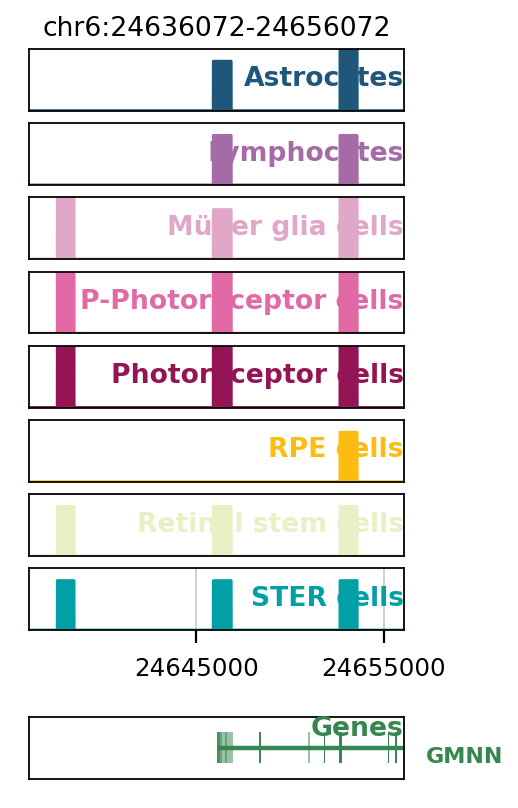

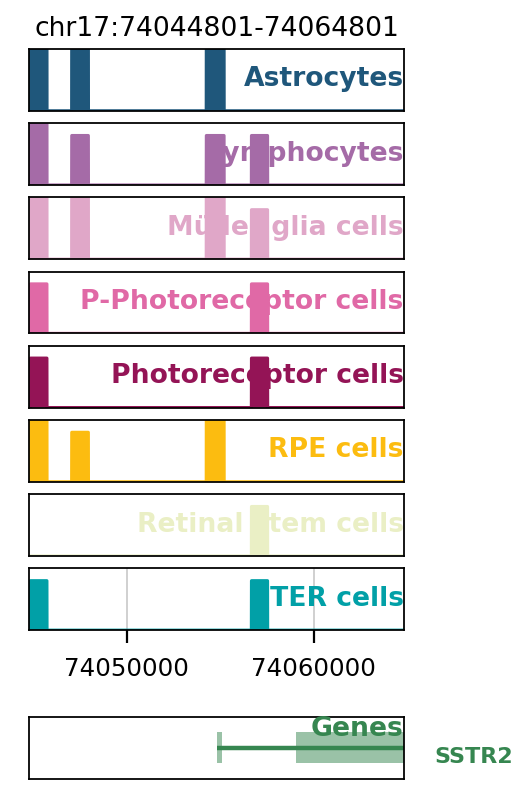

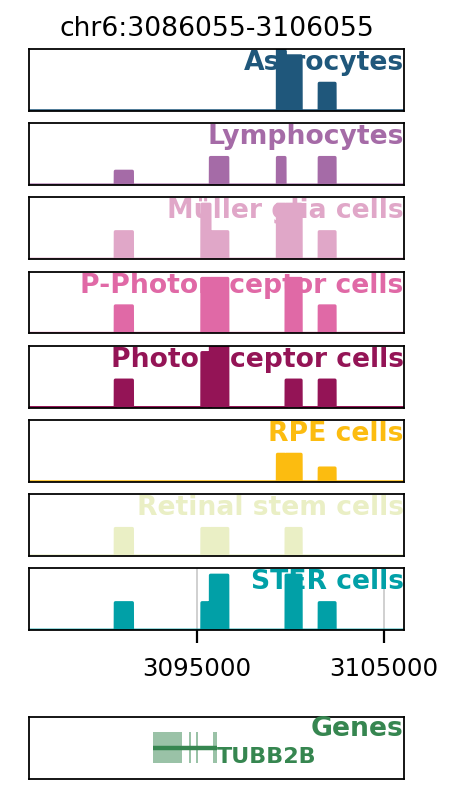

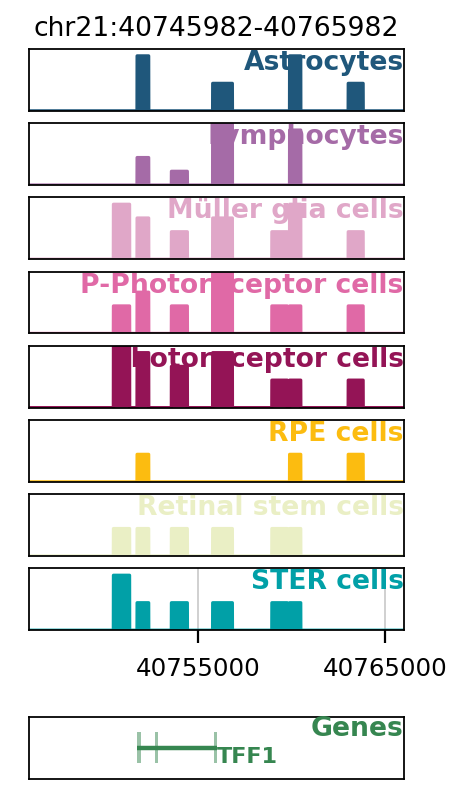

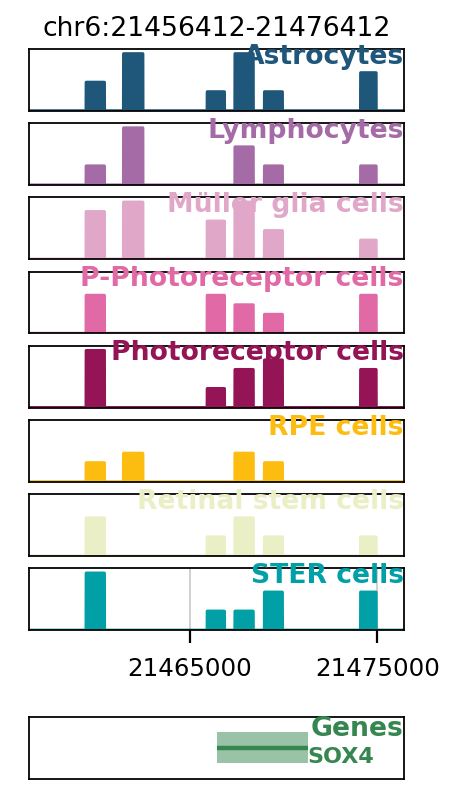

In [54]:
for a in ret_target_dict['STER cells']:
    goal_gene=a
    goal_gtf=t2tchm13_gtf.loc[t2tchm13_gtf['attribute'].str.contains('gene_id "{}"'.format(goal_gene))]
    goal_gtf1=goal_gtf.split_attribute()
    goal_gtf1=pd.DataFrame(goal_gtf1)
    goal_gtf1.head()
    #绘制特定基因在不同细胞类型中的scATAC情况
    g=goal_gtf1.loc[goal_gtf1['feature']=='gene'].iloc[0]
    #tss代表启动子
    if g.strand!='-':
        tss=g.start
    else:
        tss=g.end
    #绘制启动子前后10,000bp的区域
    plot_chr='{}:{}-{}'.format(g.seqname,tss-10000,tss+10000)
    #绘图
    fig, axes = plt.subplots(10,1,figsize=(3,6))
    #celltype代表细胞类型，num代表当前axes，color代表细胞类型的颜色
    for celltype,num,color in zip(atac.obs['major_celltype'].cat.categories,range(8),atac.uns['major_celltype_colors']):
        #细胞类型
        plot_celltype=celltype
        #绘制的染色体
        plot_chrom=plot_chr.split(':')[0]
        #绘制的染色体起点
        plot_start=int(plot_chr.split(':')[1].split('-')[0])
        #绘制的终点
        plot_end=int(plot_chr.split(':')[1].split('-')[1])
        #绘制的数据，index为染色体起点-终点的每一个值，Value代表染色体的开放程度
        plot_data=pd.DataFrame(np.zeros(plot_end-plot_start),index=range(plot_start,plot_end),columns=['Value'])
        print(celltype,plot_chrom,plot_start,plot_end)
        #选取在启动子前后10,000bp的区域内的ATAC位置
        for i in atac.var.loc[((atac.var['chrom']==plot_chrom) & (atac.var['chromStart']>plot_start)&(atac.var['chromEnd']<plot_end))].index:
            #print(i)
            #ATAC起点
            chrom_start=int(i.split('_')[1])
            #ATAC终点
            chrom_end=int(i.split('_')[2])
            #print(chrom_start,chrom_end)
            #有效表达的细胞数量
            cell_valid_len=len((atac[:,i].X[atac[:,i].X!=0]))

            if atac[atac.obs['major_celltype']==plot_celltype,i].X.sum()==0:
                #如果特定细胞中有效表达的细胞数量为0，那么全部为0
                region_cell_valid_len=0
                region_max=0
            else:
                #如果特定细胞中有效表达的细胞数不为0，那么染色体开放区域定义为该（区域内最大值*区域内有效细胞数量/全部有效细胞数量）
                yk=atac[atac.obs['major_celltype']==plot_celltype,i].X[atac[atac.obs['major_celltype']==plot_celltype,i].X!=0]
                #区域内有效细胞数量
                region_cell_valid_len=len(yk)
                #区域内最大值
                region_max=yk.max()

            #plot_data.loc[range(chrom_start,chrom_end),'Value']+=atac[atac.obs['major_celltype']==plot_celltype,i].X.toarray().reshape(-1).mean()
            plot_data.loc[range(chrom_start,chrom_end),'Value']+=region_cell_valid_len/cell_valid_len*region_max

        #绘图
        axes[num].plot(plot_data.index,plot_data.Value,c=color)
        axes[num].fill_between(plot_data.index,0,plot_data.Value,facecolor = color,alpha = 1)
        axes[num].set_xlim(plot_start,plot_end)
        #定义要画横坐标的位置，画在1/4处
        inter=(plot_end-plot_start)//4

        axes[num].set_yticks([])
        if num!=7:
            axes[num].set_xticks([])
        else:
            inter=(plot_end-plot_start)//4
            end_inter=plot_end-plot_end%inter
            start_inter=plot_end-plot_end%(inter)-inter*2
            axes[num].set_xticks([start_inter,end_inter])
        #plot_data

    #重新设置所有细胞类型的染色质开放区域的最大值，以及细胞注释的位置
    for celltype,num,color in zip(atac.obs['major_celltype'].cat.categories,range(8),atac.uns['major_celltype_colors']):
        axes[num].set_ylim(0,plot_data['Value'].max()+0.5)
        axes[num].text(plot_end,plot_data['Value'].max()-1,celltype,color=color,fontweight='bold',
                       fontsize=12,horizontalalignment = "right")

    axes[7].get_xaxis().get_major_formatter().set_scientific(False)
    axes[7].set_xticklabels([start_inter,end_inter],fontsize=11)
    axes[8].set_visible(False)

    #第二部分，绘制基因结构，exon用矩形来画

    from matplotlib.patches import Rectangle
    #fig, ax = plt.subplots(figsize=(4,1))
    print(plot_chrom,plot_start,plot_end)

    plt.hlines(y=1,xmin=g.start, xmax=g.end, color=sc_color[1], linewidth=2)


    for i in range(len(goal_gtf1.loc[goal_gtf1['feature']=='exon'])):
        exon=goal_gtf1.loc[goal_gtf1['feature']=='exon'].iloc[i]
        #print(exon.start,exon.end)
        rect = plt.Rectangle((exon.start,0.5),exon.end-exon.start,1,facecolor=sc_color[1],alpha=0.5)
        axes[9].add_patch(rect)
    axes[9].text(plot_end,1.4,'Genes',color=sc_color[1],fontweight='bold',
                       fontsize=12,horizontalalignment = "right")
    axes[0].set_title(plot_chr,fontsize=12)

    plt.xlim(plot_start,plot_end)
    plt.ylim(0,2)
    plt.text(g.end,0.5,goal_gene,fontsize=10,color=sc_color[1],fontweight='bold')
    plt.xticks([])
    plt.yticks([])
    #plt.savefig(current_path+'figure li and shi/analysis2/{}_atac.png'.format(goal_gene),dpi=300,bbox_inches='tight')

In [55]:
import os
import collections
import tables
import h5py
import scipy.io
import csv
import gzip
import scipy.sparse as sp_sparse
import argparse as ap
import pandas as pd
FeatureBCMatrix = collections.namedtuple('FeatureBCMatrix', ['ids', 'names', 'barcodes', 'matrix'])
def read_10X_h5(filename):
    """Read 10X HDF5 files, support both gene expression and peaks."""
    with tables.open_file(filename, 'r') as f:
        try:
            group = f.get_node(f.root, 'matrix')
        except tables.NoSuchNodeError:
            print("Matrix group does not exist in this file.")
            return None
        feature_group = getattr(group, 'features')
        ids = getattr(feature_group, 'id').read()
        names = getattr(feature_group, 'name').read()
        barcodes = getattr(group, 'barcodes').read()
        data = getattr(group, 'data').read()
        indices = getattr(group, 'indices').read()
        indptr = getattr(group, 'indptr').read()
        shape = getattr(group, 'shape').read()
        matrix = sp_sparse.csc_matrix((data, indices, indptr), shape=shape)
        return FeatureBCMatrix(ids, names, barcodes, matrix)

In [56]:
import os
srr_paths=['SRR13633766_CHM13_gene_score.h5',
           'SRR13633772_CHM13_gene_score.h5']
current_path='/home/leihu/data/analysis/rb_tutorial/'

In [57]:
import re
import anndata
for h_n in srr_paths:
    print(h_n)
    scatac_count=read_10X_h5(current_path+'data/geneactivity/'+h_n)
    peakmatrix = scatac_count.matrix
    features = scatac_count.names.tolist()
    features = [re.sub("\W", "_", feature.decode()) for feature in features]
    features = [feature.encode() for feature in features]
    barcodes = scatac_count.barcodes.tolist()
    adata=anndata.AnnData(peakmatrix.T,obs=barcodes,var=features)
    adata.obs.index=[i.decode('utf-8') for i in adata.obs[0]]
    adata.var.index=[i.decode('utf-8') for i in adata.var[0]]
    del adata.obs[0]
    del adata.var[0]

SRR13633766_CHM13_gene_score.h5
SRR13633772_CHM13_gene_score.h5


In [58]:
atac_meta=pd.read_csv(current_path+'data/meta/RB_atac_meta.csv',index_col=0)
atac_meta.head()

,Run,BioSample,Bases,Bytes,Developmental_Stage,Experiment,GEO_Accession,Sample Name,source_name,Tissue
1,SRR13633765,SAMN17796941,36.97 G,11.22 Gb,20PCW,SRX10031197,GSM5065170,GSM5065170,Retina,Retina
2,SRR13633766,SAMN17796939,39.16 G,11.81 Gb,Retinoblastoma_4months,SRX10031198,GSM5065171,GSM5065171,Retinoblastoma,Retinoblastoma
3,SRR13633767,SAMN17796938,43.63 G,13.21 Gb,12PCW,SRX10031199,GSM5065172,GSM5065172,Retina,Retina
4,SRR13633768,SAMN17796936,44.50 G,13.35 Gb,16PCW,SRX10031200,GSM5065173,GSM5065173,Retina,Retina
5,SRR13633769,SAMN17796934,46.94 G,14.15 Gb,12PCW,SRX10031201,GSM5065174,GSM5065174,Retina,Retina


In [59]:
import scanpy as sc
import anndata
name='SRR13633766'
adata=sc.read(current_path+'data/geneactivity/{}_CHM13_gene_mact.h5ad'.format(name))
adata.var_names_make_unique()
adata.obs_names_make_unique()
adata.obs.index=['{}-{}'.format(i,name) for i in adata.obs.index]
adata.obs['SRR']=name
adata.obs['Cancer']='RB'
adata.obs['Tissue']=atac_meta.loc[atac_meta['Run']==name,'Tissue'].values[0]
adata.obs['Developmental_Stage']=atac_meta.loc[atac_meta['Run']==name,'Developmental_Stage'].values[0]
adata

AnnData object with n_obs × n_vars = 20001 × 59454
    obs: 'SRR', 'Cancer', 'Tissue', 'Developmental_Stage'

In [60]:
for srr_name in ['SRR13633766','SRR13633772']:
    if srr_name=='SRR13633766':
        continue
    else:
        name=srr_name
        adata1=sc.read(current_path+'data/geneactivity/{}_CHM13_gene_mact.h5ad'.format(name))
        adata1.var_names_make_unique()
        adata1.obs_names_make_unique()
        adata1.obs.index=['{}-{}'.format(i,name) for i in adata1.obs.index]
        adata1.obs['SRR']=name
        adata1.obs['Cancer']='RB'
        adata1.obs['Tissue']=atac_meta.loc[atac_meta['Run']==name,'Tissue'].values[0]
        adata1.obs['Developmental_Stage']=atac_meta.loc[atac_meta['Run']==name,'Developmental_Stage'].values[0]

        adata=anndata.concat([adata,adata1],merge='same')
adata

AnnData object with n_obs × n_vars = 40032 × 59454
    obs: 'SRR', 'Cancer', 'Tissue', 'Developmental_Stage'

In [ ]:
adata_rna=sc.read(current_path+'data/analysis1/rna_anno.h5ad')

In [ ]:
import mudata

mdata=mudata.read(current_path+'data/analysis1/muatac_anno.h5mu')
adata_atac=mdata.mod["atac"]
adata_act=mdata.mod["act"]
adata_motif=mdata.mod["motif"]

In [ ]:
for srr_name in ['NHLH2','TFF1','TUBB2B','SSTR2','GMNN','SOX4']:
    if srr_name=='NHLH2':
        continue
    else:
        fig, axes = plt.subplots(1,2,figsize=(6,3))
        gene=srr_name
        for ad,num,name,c,vmax in zip([adata_rna,adata_act],range(2),['RNA','ACT'],['PuRd','Oranges'],[5,1]):
            sc.pl.embedding(
            ad,
            basis="X_umap",
            color=[gene],
            title=name,
            frameon=False,
            ncols=3,
            #save='_figure1_celltype.png',
            #return_fig=True,
            wspace=0.5,
            show=False,
            cmap=c,
            vmin=0,
            vmax=vmax,
            ax=axes[num]
            #palette=sc_color[11:],
            )
            axes[num].set_title(name+'\n'+gene,fontsize=12)
        #fig.savefig(current_path+'figure li and shi/analysis1/{}_multiomics.png'.format(gene),dpi=300,bbox_inches='tight')

In [ ]:
ax=sc.pl.violin(adata_rna, ['SOX4','TFF1','NHLH2'], groupby='major_celltype',fig_size=(9,3),
             stripplot=False, jitter=0.2, multi_panel=False,show=False,return_fig=True )
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)
ax[0].set_xlabel('')
ax[0].set_title('SOX4')
ax[0].set_ylabel('RNA expression')
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_title('TFF1')
ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation=90)
ax[2].set_xlabel('')
ax[2].set_ylabel('')
ax[2].set_title('NHLH2')
#plt.savefig(current_path+'figure li and shi/analysis1/rna_violin1.png',dpi=300,bbox_inches='tight')

In [ ]:
ax=sc.pl.violin(adata_rna, ['TUBB2B','SSTR2','GMNN'], groupby='major_celltype',fig_size=(9,3),
             stripplot=False, jitter=0.2, multi_panel=False,show=False,return_fig=True )
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)
ax[0].set_xlabel('')
ax[0].set_title('TUBB2B')
ax[0].set_ylabel('RNA expression')
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_title('SSTR2')
ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation=90)
ax[2].set_xlabel('')
ax[2].set_ylabel('')
ax[2].set_title('GMNN')
#plt.savefig(current_path+'figure li and shi/analysis1/rna_violin2.png',dpi=300,bbox_inches='tight')

In [ ]:
ax=sc.pl.violin(adata_act, ['TUBB2B','SSTR2','GMNN'], groupby='major_celltype',fig_size=(9,3),
             stripplot=False, jitter=0.2, multi_panel=False,show=False,return_fig=True )
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)
ax[0].set_xlabel('')
ax[0].set_title('TUBB2B')
ax[0].set_ylabel('Chromatin Activity')
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_title('SSTR2')
ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation=90)
ax[2].set_xlabel('')
ax[2].set_ylabel('')
ax[2].set_title('GMNN')
#plt.savefig(current_path+'figure li and shi/analysis1/act_violin2.png',dpi=300,bbox_inches='tight')

In [ ]:
ax=sc.pl.violin(adata_act, ['SOX4','TFF1','NHLH2'], groupby='major_celltype',fig_size=(9,3),
             stripplot=False, jitter=0.2, multi_panel=False,show=False,return_fig=True )
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)
ax[0].set_xlabel('')
ax[0].set_title('SOX4')
ax[0].set_ylabel('Chromatin Activity')
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_title('TFF1')
ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation=90)
ax[2].set_xlabel('')
ax[2].set_ylabel('')
ax[2].set_title('NHLH2')
#plt.savefig(current_path+'figure li and shi/analysis1/act_violin1.png',dpi=300,bbox_inches='tight')